# Transfer Learning: Fine-Tuning
Fine-tuning is a type of transfer learning.  
Transfer learning (briefly):
- uses existing pre-trained models
- adjusts the use of the model to your/my use-case

Fine-Tuning adjusts layers in the starting model. Fine-tuning adjusts _more layers than a "feature extraction" transfer learning setup._  

## Notebook Goals
- **review differences** between the sequential and functional apis for tf keras model development
- **import a series of "helper" functions** from an external source
- **import & split data into training & testing datasets** using `tf.keras.preprocessing.image_dataset_from_directory`
- **build a model** using the keras "functional" style api
- **save model logs to a csv file** using a csv callback function

 
## Functional API for Model-Creation
### A "Sequential" Approach
```python

# CREATE
sequential_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation="relu"),
tf.keras.layers.Dense(64, activation="relu"),
tf.keras.layers.Dense(10, activation="softmax"),
], name="sequential_model")


# COMPILE
sequential_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# FIT to data
sequential_model.fit(x_training_data, y_training_data, batch_size=32, epoch=5)
```

### A Functional Approach
```python

# CREATE
inputLayer = tf.keras.layers.Input(shape=(28,28))

appliedModel = tf.keras.layers.Flatten(inputLayer)
appliedModel = tf.keras.layers.Dense(64, activation="relu")(appliedModel)
appliedModel = tf.keras.layers.Dense(64, activation="relu")(appliedModel)

appliedOutput = tf.keras.layers.Dense(10, activation="softmax")(appliedModel)

functional_model = tf.keras.Model(inputLayer, appliedOutput, name="functional_model")


# COMPILE
functional_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# FIT to data
functional_model.fit(x_training_data, y_training_data, batch_size=32, epoch=5)
```

### Functional & Sequential Syntax Comparison
- compile and fit are the same
- functional "is more flexible"

### DEFINITION: feature vector
a "feature" representation of input data

## Imports

In [23]:
import tensorflow as tf
from keras.callbacks import CSVLogger

## Download & Import Helper Functions

In [2]:
# Download helper_functions.py script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-06-26 11:23:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-26 11:23:06 (11.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get Data
Transfer learning can leverage _less training data_ than building a model from scratch.

### Download the data

In [3]:
# Get SMALL set of data based on the food101 dataset
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

In [4]:
# 
# check out some data 
# 
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

### Setup Some Variables

In [5]:
data_dir_path = "10_food_classes_10_percent/"
train_dir_path = data_dir_path + "train/"
test_dir_path = data_dir_path + "test/"
IMG_OUTPUT_SIZE = (224, 224)
labelMode = "categorical"
# batchSize = 32
batchSize = 24

### Split Data Into Train & Test
Using the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory), we can create 2 tensorflow datasets

In [6]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path,
                                                                            image_size=IMG_OUTPUT_SIZE,
                                                                            label_mode=labelMode,
                                                                            batch_size=batchSize)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path,
                                                                           image_size=IMG_OUTPUT_SIZE,
                                                                           label_mode=labelMode)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Inspect the created dataset vars

In [7]:
# see what one of the vars is...
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# 
# see ALL methods available on the new vars
# 

# dir(train_data_10_percent)

In [10]:
# 
# preview some data using the "take" method
# 

# for images, labels in train_data_10_percent.take(1):
#   print(images,labels)

## Model: Transfer-Learning I

In [24]:
modelName = 'm0'
lessValidationDataCount = int(0.25 * len(test_data_10_percent))
csv_logger = CSVLogger(f'{modelName}-log.csv', append=True, separator=';')

# 
# pre-trained model
# 
# 1. Create base model with tf.keras.applications
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 
# custom layer(s)
# 
# 3. Create inputLayer into the base model
inputLayer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")


# "4" If using ResNet50V2, add this to speed up convergence by rescaling inputs
# NOT for EfficientNetV2
# appliedModel = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputLayer)


# 5. Apply the inputLayer to the base_model (note: using tf.keras.applications, EfficientNetV2 inputLayer don't have to be normalized)
appliedModel = base_model(inputLayer)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
appliedModel = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedModel)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(appliedModel)

# 8. Combine the inputLayer with the outputs into a model
m0 = tf.keras.Model(inputLayer, outputs)

# 9. Compile the model
m0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
m0History = m0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through LESS of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=lessValidationDataCount,
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract"), csv_logger])

Shape after base_model: (None, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240626-121903
Epoch 1/5
32/32 [==============================] - 43s 1s/step - loss: 1.8216 - accuracy: 0.4587 - val_loss: 1.2248 - val_accuracy: 0.7566
Epoch 2/5
32/32 [==============================] - 34s 1s/step - loss: 1.0554 - accuracy: 0.7533 - val_loss: 0.8196 - val_accuracy: 0.8240
Epoch 3/5
32/32 [==============================] - 41s 1s/step - loss: 0.7753 - accuracy: 0.8320 - val_loss: 0.6813 - val_accuracy: 0.8487
Epoch 4/5
32/32 [==============================] - 34s 1s/step - loss: 0.6335 - accuracy: 0.8613 - val_loss: 0.5982 - val_accuracy: 0.8470
Epoch 5/5
32/32 [==============================] - 34s 1s/step - loss: 0.5509 - accuracy: 0.8867 - val_loss: 0.5562 - val_accuracy: 0.8635


## Inspect The Model & Results
### Model Layers

In [13]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

### Model Summary

In [14]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
m0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

### Visualize Loss & Accuracy Curves

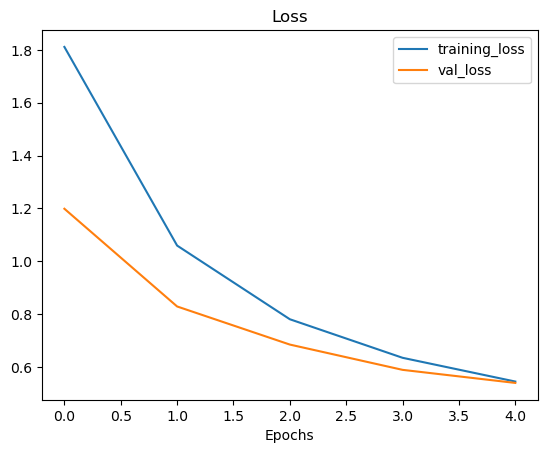

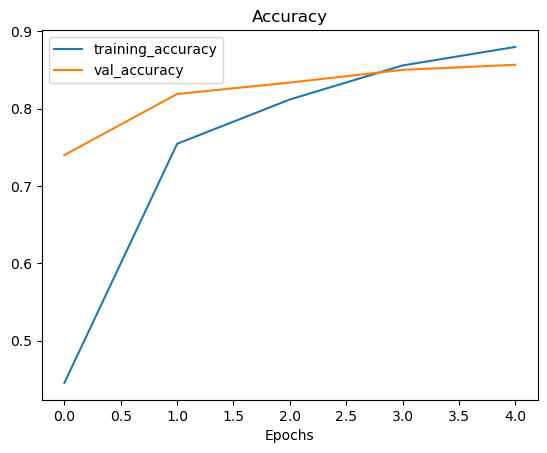

In [16]:
plot_loss_curves(m0History)

### A Layer-in-action: GlobalAveragePooling2D
Here:
- create a random input tensor
- apply the `GlobalAveragePooling2D` keras layer
- see the impact of the layer on the input data

In [18]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [20]:
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]



In [21]:
# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


### Reduce Mean to get the same

In [22]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

### A Layer-in-action: GlobalMaxPool2D

In [27]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [28]:
print(f"global_max_pooled_tensor:\n {global_max_pooled_tensor}\n")

global_max_pooled_tensor:
 [[0.9058464 1.1603122 1.6994323]]



In [29]:
# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")
print(f"Shape of global_max_pooled_tensor: {global_max_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)
Shape of global_max_pooled_tensor: (1, 3)
